Revert Classification - Demo
===

Building a classifier to predict reverts and produce calibrated propensity scores for being reverted.

This notebook is a pared-down demo notebook created for Solvejg.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import os
from tqdm import tqdm
import bz2
import sqlite3
import difflib
import gzip
import json
import re
import hashlib
from datetime import datetime
from datetime import timezone
import nltk
import scipy.stats
import para
from itertools import groupby
from collections import Counter

In [3]:
import sklearn
import sklearn.ensemble
import sklearn.metrics
import sklearn.calibration

In [4]:
raw_data_dir = "/export/scratch2/wiki_data"
derived_data_dir = os.path.join('/export/scratch2/levon003/repos/wiki-ores-feedback', "data", "derived")
raw_data_dir, derived_data_dir

('/export/scratch2/wiki_data',
 '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived')

In [5]:
stub_history_dir = os.path.join(derived_data_dir, 'stub-history-all-revisions')
stub_history_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/stub-history-all-revisions'

In [6]:
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
working_dir = os.path.join(derived_data_dir, 'audit')
working_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/audit'

### Data loading and cleaning

In [7]:
# read in the sample dataframe
s = datetime.now()
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
sample3_filepath = os.path.join(revision_sample_dir, 'sample3_all.pkl')
rev_df = pd.read_pickle(sample3_filepath)
print(f"Sample 3 data loaded in {datetime.now() - s}.")
len(rev_df)

Sample 3 data loaded in 0:00:32.805432.


33964442

In [8]:
rev_df.head()

,page_id,rev_id,rev_timestamp,is_revert_target,is_reverted,is_reverting,is_sample_eligible,prev_rev_id,next_rev_id,prev_rev_timestamp,next_rev_timestamp,reverted_rev_ids,reverting_rev_id,reverting_rev_timestamp
1,12,818613649,1515102279,0,0,0,True,818611292,818624114,1515101356,1515106953,[],-1,-1
2,12,818624114,1515106953,1,0,0,True,818613649,820024812,1515102279,1515798752,[],-1,-1
3,12,820024812,1515798752,0,1,0,True,818624114,820025687,1515106953,1515799060,[],820025687,1515799060
4,12,820025687,1515799060,0,0,1,True,820024812,820703495,1515798752,1516095884,[820024812],-1,-1
5,12,820703495,1516095884,0,0,0,True,820025687,821673418,1515799060,1516597634,[],-1,-1


In [9]:
# Load the features
s = datetime.now()
labeled_revs_dir = os.path.join(derived_data_dir, 'labeled-revs')
sample3_features_dir = os.path.join(labeled_revs_dir, 'sample3-features')
sample3_damaging_filepath = os.path.join(sample3_features_dir, 'sample3.damaging.2020-07-11T15:11:15Z.tsv')
features_df = pd.read_csv(sample3_damaging_filepath, sep='\t', header=0)
print(f"Features data loaded in {datetime.now() - s}.")
len(features_df)

Features data loaded in 0:00:45.903728.


4005652

In [10]:
# drop the useless 'damaging' column (it is auto-generated)
features_df = features_df.drop(columns='damaging')

In [11]:
# load in the rev_ids that correspond to the feature data
# this is really slow, because it requires JSON decoding
# this could be made faster by caching the result
cache_filepath = os.path.join(labeled_revs_dir, 'sample3-features', 'sample3.mock.w_cache.2020-07-11T15:11:15Z.json')
cache_rev_id_list = []
with open(cache_filepath, 'r') as infile:
    for line in tqdm(infile, total=len(features_df)):
        rev = json.loads(line)
        rev_id = rev['rev_id']
        cache_rev_id_list.append(rev_id)

100%|██████████| 4005652/4005652 [02:07<00:00, 31395.92it/s]


In [12]:
assert len(cache_rev_id_list) == len(features_df)

In [13]:
cache_rev_id_set = set(cache_rev_id_list)
len(cache_rev_id_set)

4005602

In [14]:
# use use the last revision in this same to figure out when the analysis end time should be
last_rev = cache_rev_id_list[-1]
last_rev

826425205

In [15]:
# every rev_id in the cache should ALSO be in the rev_df
assert len(cache_rev_id_set & set(rev_df.rev_id)) == len(cache_rev_id_set), len(cache_rev_id_set & set(rev_df.rev_id))

In [16]:
# set the analysis start time to be the beginning of 2018
analysis_start_date = datetime.fromisoformat('2018-01-01')
analysis_start_date = analysis_start_date.replace(tzinfo=timezone.utc)
analysis_start_timestamp = int(analysis_start_date.timestamp())
print(f"Starting analysis from {datetime.utcfromtimestamp(analysis_start_timestamp)}")

Starting analysis from 2018-01-01 00:00:00


In [17]:
# note that this is less than 2 months of data right now!
# we have 20-25 million downloaded, but this 4 million set should be enough to get going
analysis_end_timestamp = rev_df[rev_df.rev_id == last_rev].rev_timestamp.iloc[0]
print(f"Using revisions up to {datetime.utcfromtimestamp(analysis_end_timestamp)}")

Using revisions up to 2018-02-19 07:18:15


In [18]:
# mostly to save memory, we trim out unneeded data in the rev_df
rev_df = rev_df[(rev_df.rev_timestamp <= analysis_end_timestamp)&(rev_df.rev_timestamp >= analysis_start_timestamp)]
len(rev_df)

4025634

In [19]:
# Read the revert info
# This dataframe contains additional data beyond what is in the rev_df
s = datetime.now()
stub_history_reverts_dir = os.path.join(derived_data_dir, 'stub-history-reverts')
revert_df_filepath = os.path.join(stub_history_reverts_dir, 'revert_df.pkl')
revert_df = pd.read_pickle(revert_df_filepath)
print(f"Loaded revert data in {datetime.now() - s}.")
len(revert_df)

Loaded revert data in 0:00:31.438184.


5992682

The most important info in the `revert_df` that isn't in the `rev_df` is the username info, which enables the identification of self-reverts.

`revert_df` has one line per **revert** revision, compared to the `rev_df` which has one line per revision.

In [20]:
revert_df.head()

,page_id,reverted_count,reverting_rev_id,reverting_timestamp,reverting_user_text,reverting_user_id,reverted_to_rev_id,reverted_to_timestamp,reverted_to_user_text,reverted_to_user_id,reverted_rev_ids,reverted_timestamps,reverted_user_texts,reverted_user_ids,reverting_user_is_anonymous,reverted_to_user_is_anonymous,reverted_users_is_anonymous
0,18754764,1,902766646,1561105801,Malcolmxl5,4076676.0,874884880,1545481829,Hmains,508734.0,[900328973],[1559706521],[2601:199:417F:8EED:A0B0:A6B5:3457:A9B4],[None],False,False,[True]
1,18754831,2,818980415,1515284429,BrownHairedGirl,754619.0,743241620,1475970276,Emir of Wikipedia,28856560.0,"[757539852, 775847398]","[1483188655, 1492452285]","[Ser Amantio di Nicolao, Emir of Wikipedia]","[753665, 28856560]",False,False,"[False, False]"
2,18754831,1,932235094,1577204938,UA3,25923702.0,918313790,1569654385,Monkbot,20483999.0,[932233860],[1577204033],[Qowa],[37692801],False,False,[False]
3,18754864,1,853153047,1533256539,Beetstra,855858.0,831996274,1521801439,KolbertBot,31691822.0,[846149041],[1529188413],[Lepidoptera~plwiki],[24892933],False,False,[False]
4,18754916,1,882182106,1549557841,Number 57,327289.0,847748130,1530126769,CitationCleanerBot,15270283.0,[882125775],[1549520001],[Huldra],[410653],False,False,[False]


In [21]:
# identify self-reverts
is_self_revert_list = []
for row in tqdm(revert_df.itertuples(), total=len(revert_df)):
    is_self_revert = row.reverting_user_text in row.reverted_user_texts
    is_self_revert_list.append(is_self_revert)
revert_df['is_self_revert'] = is_self_revert_list

100%|██████████| 5992682/5992682 [00:21<00:00, 283509.42it/s]


In [22]:
# only keep reverts that appear in the (filtered) rev_df
analysis_rev_ids = set(rev_df.rev_id)
revert_subset = revert_df[revert_df.reverting_rev_id.isin(analysis_rev_ids)].copy()
len(revert_subset), len(revert_subset) / len(revert_df)

(427375, 0.07131614859590414)

In [23]:
# now compute the outcome, which is a variant of `rev_df.is_reverted`
reverted_rev_ids = set()
# only count it as a reverted revision if it was not a self-revert
# and it was reverted within one week
threshold = 60 * 60 * 24 * 7 
rs = revert_subset[~revert_subset.is_self_revert]
for row in tqdm(rs.itertuples(), total=len(rs)):
    reverting_timestamp = row.reverting_timestamp
    for rev_id, timestamp in zip(row.reverted_rev_ids, row.reverted_timestamps):
        if reverting_timestamp - timestamp <= threshold:
            reverted_rev_ids.add(rev_id)
len(reverted_rev_ids)

100%|██████████| 377374/377374 [00:02<00:00, 177400.07it/s]


501159

In [24]:
# just for fun, we'll compare how the revised revert outcome we computed in the cell above compares to 
# the broader definition of reverting
rev_df['is_reverted_for_damage'] = rev_df.rev_id.map(lambda rev_id: rev_id in reverted_rev_ids)

In [25]:
# our revised revert measure trims off 84251 of 499347 (16.9%) of the total reverts
# as expected, all revisions with is_reverted == 0 also have is_reverted_for_damage == 1
pd.crosstab(rev_df.is_reverted, rev_df.is_reverted_for_damage, margins=True)

is_reverted_for_damage,False,True,All
is_reverted,,,
0,3526287,0,3526287
1,84251,415096,499347
All,3610538,415096,4025634


In [26]:
84251 / 499347

0.16872235139091654

#### Create the actual outcome variable and add it to the features dataframe

`features_df` contains only the features, not the revision ids. We create a binary outcome column based on the order of the revisions as they were read from the cache (and stored in `cache_rev_id_list`).

In [27]:
is_reverted = [rev_id in reverted_rev_ids for rev_id in cache_rev_id_list]
features_df['is_reverted'] = is_reverted
np.sum(features_df.is_reverted), np.sum(features_df.is_reverted) / len(features_df)

(411650, 0.10276728981948506)

### Fit classification models

In [28]:
clf1 = sklearn.ensemble.GradientBoostingClassifier(
    learning_rate=0.01, 
    n_estimators=700, 
    max_features='log2', 
    max_depth=5
)

clf2 = sklearn.linear_model.LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs'
)

clf3 = sklearn.linear_model.LogisticRegression(
    penalty='none',
    solver='lbfgs',
    max_iter=1000
)

# shuffle the data and give it a shorter name
df = features_df.sample(frac=1)

# for this demonstration, not using cross validation
# just using a random train/test split
train, test = sklearn.model_selection.train_test_split(df, test_size=0.2)

# for the demo, using just a subset of the data
# even with only 4 million revisions, training the GB model takes a full 20 minutes! (and we're not even cross-validating...)
# note that number of samples probably also affects number of required iterations for gradient-descent based models (like logistic regression)
train = train.sample(n=10000)

# in my experience so far, scaling is very important for the Gradient-Boosting model...
X_train = sklearn.preprocessing.scale(train.iloc[:,:-1])
X_test = sklearn.preprocessing.scale(test.iloc[:,:-1])

clf_results = []
for clf in [clf3, clf2, clf1]:
    s = datetime.now()
    print(clf)

    
    # train the model
    md = clf.fit(X_train, train.iloc[:,-1])
    
    # predict with the model
    y_pred_test = md.predict(X_test)
    y_pred_test_proba = md.predict_proba(X_test)[:,1]
    y_test = test.is_reverted
    # save the results so we can do things with them
    clf_results.append([y_pred_test, y_pred_test_proba, y_test])
    print(f"Training completed in {datetime.now() - s}.")


LogisticRegression(max_iter=1000, penalty='none')


/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training completed in 0:00:02.775729.
LogisticRegression()


/export/scratch2/levon003/bin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training completed in 0:00:00.360961.
GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features='log2',
                           n_estimators=700)
Training completed in 0:01:03.595824.


LR (no reg); accuracy: 88.901%; test ROC AUC: 0.8182; % reverted; 0.049652304055142045
              precision    recall  f1-score   support

       False       0.91      0.97      0.94    718781
        True       0.42      0.20      0.27     82350

    accuracy                           0.89    801131
   macro avg       0.67      0.58      0.61    801131
weighted avg       0.86      0.89      0.87    801131


LR (L2 reg); accuracy: 90.079%; test ROC AUC: 0.8438; % reverted; 0.016365613114459433
              precision    recall  f1-score   support

       False       0.91      0.99      0.95    718781
        True       0.61      0.10      0.17     82350

    accuracy                           0.90    801131
   macro avg       0.76      0.54      0.56    801131
weighted avg       0.88      0.90      0.87    801131


GB Tree; accuracy: 90.610%; test ROC AUC: 0.8503; % reverted; 0.04034046866242849
              precision    recall  f1-score   support

       False       0.92      0.98

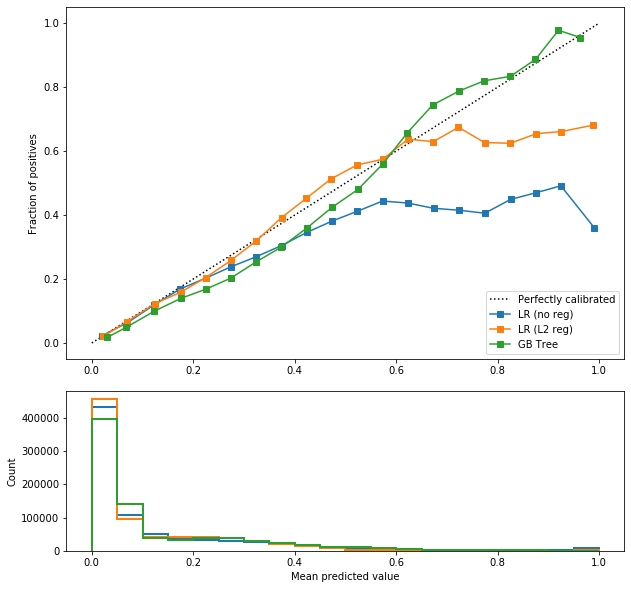

In [29]:
fig = plt.figure(0, figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for label, tup in zip(['LR (no reg)', 'LR (L2 reg)', 'GB Tree'], clf_results):
    y_pred_test, y_pred_test_proba, y_test = tup
    frac_of_pos, mean_pred_value = sklearn.calibration.calibration_curve(y_test, y_pred_test_proba, n_bins=20)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=label)
    ax1.set_ylabel("Fraction of positives")
    ax2.hist(y_pred_test_proba, range=(0, 1), bins=20, histtype="step", lw=2, log=False)
    
    acc_test = np.sum(y_pred_test == y_test) / len(y_pred_test)
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_test_proba)
    print(f"{label}; accuracy: {acc_test*100:.3f}%; test ROC AUC: {roc_auc:.4f}; % reverted; {np.sum(y_pred_test) / len(y_test)}")
    print(sklearn.metrics.classification_report(y_test, y_pred_test))
    print()
    
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")

plt.show()

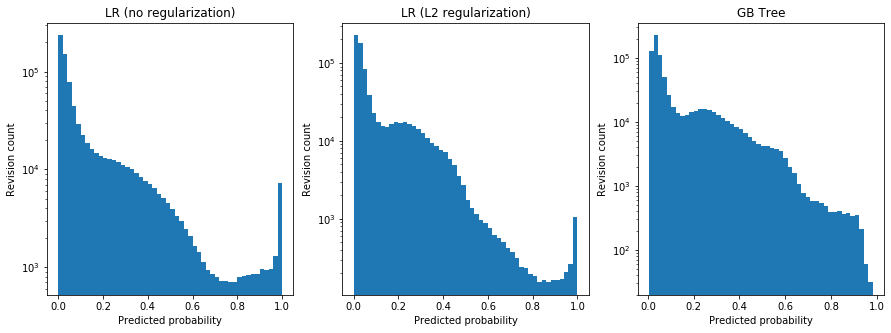

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax_title_tup in enumerate(zip(axes, ['LR (no regularization)', 'LR (L2 regularization)', 'GB Tree'])):    
    ax, title = ax_title_tup
    ax.hist(clf_results[i][1], bins=50, log=True)
    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Revision count")
    ax.set_title(title)
plt.show()